In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
plt.rcParams.update({'font.size': 11})

In [2]:
#load data
df = pd.read_csv('user_data.csv')

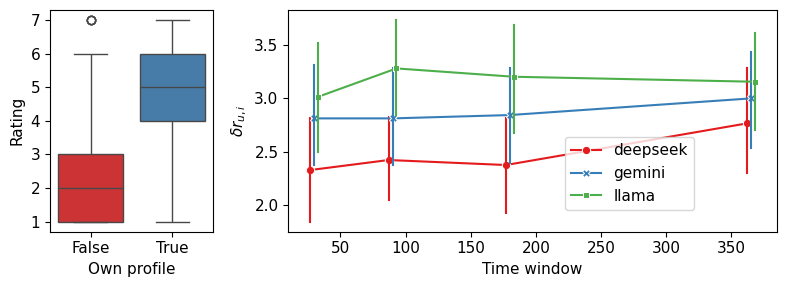

In [3]:
#plot ratings
fig, axes = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={'width_ratios': [1, 3]})

sns.boxplot(data=df, y='rating', x='is_own_profile', hue = 'is_own_profile', palette = 'Set1', ax=axes[0], legend=False)
axes[0].set_xlabel("Own profile")
axes[0].set_ylabel("Rating")

offsets = {'deepseek-r1': -3, 'gemini-2.0-flash': 0, 'llama3.2:3b-instruct-q8_0': 3}
df['x_dodged'] = df.apply(lambda row: row['time_window'] + offsets[row['model']], axis=1)

sns.lineplot(data = df[df.is_own_profile == True], x = 'x_dodged', y = 'delta_rating', hue = 'model',linewidth = 1.5, palette = 'Set1', err_style="bars", ax =axes[1], style = 'model', markers=True, dashes=False)

# Custom legend
handles, labels = axes[1].get_legend_handles_labels()
custom_labels = ['deepseek', 'gemini', 'llama']
axes[1].legend(
    handles=handles,
    labels=custom_labels,
    bbox_to_anchor=(0.55, 0.46) # x and y in axes coordinates (0 to 1)
)

axes[1].set_xlabel("Time window")
axes[1].set_ylabel("$\delta r_{u,i}$")

plt.tight_layout()

In [4]:
# Perform ANOVA
model = ols('delta_rating ~ C(model)*C(time_window)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                              sum_sq      df         F    PR(>F)
C(model)                   47.702223     2.0  5.158085  0.005896
C(time_window)             22.002227     3.0  1.586080  0.191049
C(model):C(time_window)     7.735597     6.0  0.278819  0.947056
Residual                 4975.450794  1076.0       NaN       NaN


In [5]:
rows = ['recall@10','ndcg@10']
temp = df[df.is_own_profile == True].dropna(subset = rows)
scaler = MinMaxScaler()
predictor = 'delta_rating'
n_bootstrap = 50

results = []

for model in temp.model.unique():
    temp2 = temp[(temp.model == model)].dropna().copy()
    temp2[rows] = scaler.fit_transform(temp2[rows])
    
    for outcome in tqdm(rows):
        coefs = []

        for _ in range(n_bootstrap):
            sample = resample(temp2)
            x_sample = sample[predictor].values.reshape(-1, 1)
            y_sample = sample[outcome].values
            reg = LinearRegression().fit(x_sample, y_sample)
            # Get index of current predictor
            coef = reg.coef_[0]
            coefs.append(coef)

        coefs = np.array(coefs)
        mean_coef = np.mean(coefs)
        ci_lower = np.percentile(coefs, 2.5)
        ci_upper = np.percentile(coefs, 97.5)

        results.append({
            'model': model,
            'outcome': outcome,
            'mean': mean_coef,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })

# Convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s]


In [6]:
results_df['plot_model'] = 'llama'
results_df.loc[results_df.model == 'deepseek-r1', 'plot_model'] = 'deepseek'
results_df.loc[results_df.model == 'gemini-2.0-flash', 'plot_model'] = 'gemini'
plt.rcParams.update({'font.size': 14})
df['recall'] = 100*df['recall@10']

Text(0, 0.5, 'Recall@10 (%)')

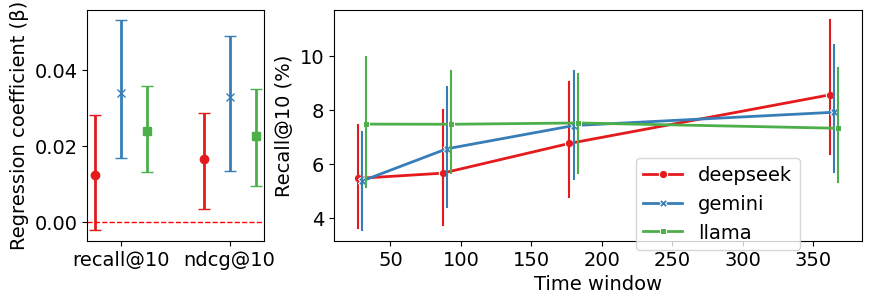

In [7]:
model_markers = {
    'deepseek': 'o', 
    'gemini': 'x', 
    'llama': 's'
}

fig, axes = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 3]})

# Get unique models and outcomes
models = results_df['plot_model'].unique()
outcomes = results_df['outcome'].unique()

# Prepare color mapping using Set1
palette = sns.color_palette("Set1", n_colors=len(models))
model_colors = dict(zip(models, palette))

# X positions for grouped points
group_width = 0.24
x_positions = []
x_labels = []

for i, outcome in enumerate(outcomes):
    for j, model in enumerate(models):
        x = i + j * group_width - group_width  # small offset for grouped points
        x_positions.append((x, outcome, model))
        x_labels.append(outcome if j == 0 else "")

# Plot each point with error bar
for (x, outcome, model) in x_positions:
    row = results_df[(results_df['outcome'] == outcome) & (results_df['plot_model'] == model)].iloc[0]
    y = row['mean']
    yerr = [[y - row['ci_lower']], [row['ci_upper'] - y]]
    axes[0].errorbar(
        x, y, yerr=yerr, marker = model_markers.get(model, 'o'), color=model_colors[model],elinewidth =2  , 
        capsize=4, label=model if x_labels[x_positions.index((x, outcome, model))] else ""
    )

axes[0].axhline(0, color='red', linestyle='--', linewidth=1)

# Customize plot
axes[0].set_xticks([i for i in range(len(outcomes))])
axes[0].set_xticklabels(outcomes)
axes[0].set_ylabel("Regression coefficient (β)")

offsets = {'deepseek-r1': -3, 'gemini-2.0-flash': 0, 'llama3.2:3b-instruct-q8_0': 3}
df['x_dodged'] = df.apply(lambda row: row['time_window'] + offsets[row['model']], axis=1)

sns.lineplot(data = df, x = 'x_dodged', y = 'recall', hue = 'model',linewidth = 2, palette = 'Set1',
             err_style="bars", ax =axes[1], style = 'model', markers=True, dashes=False)


# Custom legend
handles, labels = axes[1].get_legend_handles_labels()
custom_labels = ['deepseek', 'gemini', 'llama']
axes[1].legend(
    handles=handles,
    labels=custom_labels,
    bbox_to_anchor=(0.9, 0.4)
)



axes[1].set_xlabel("Time window")
axes[1].set_ylabel("Recall@10 (%)")


In [8]:
df = df[df.is_own_profile == True].copy()

In [9]:
outcome = 'delta_rating' # also recall@10 and ndcg@10
predictors = ['gs_score', 'mean_age_songs', 'median_rank','active_eng']
n_bootstrap = 500
scaler = MinMaxScaler()

plt.rcParams.update({'font.size': 14})
results = []

for model in df.model.unique():
    temp = df[df.model == model].dropna().copy()
    temp[predictors] = scaler.fit_transform(temp[predictors])

    for predictor in tqdm(predictors):
        coefs = []

        for _ in range(n_bootstrap):
            sample = resample(temp)
            x_sample = sample[predictor].values.reshape(-1, 1)
            y_sample = sample[outcome].values
            reg = LinearRegression().fit(x_sample, y_sample)
            # Get index of current predictor
            coef = reg.coef_[0]
            coefs.append(coef)

        coefs = np.array(coefs)
        mean_coef = np.mean(coefs)
        ci_lower = np.percentile(coefs, 2.5)
        ci_upper = np.percentile(coefs, 97.5)

        results.append({
            'model': model,
            'predictor': predictor,
            'mean': mean_coef,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })

# Convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


In [10]:
results_df['plot_model'] = 'llama'
results_df.loc[results_df.model == 'deepseek-r1', 'plot_model'] = 'deepseek'
results_df.loc[results_df.model == 'gemini-2.0-flash', 'plot_model'] = 'gemini'

results_df.loc[results_df.predictor == 'gs_score', 'predictor'] = 'GS-score'

results_df.loc[results_df.predictor == 'median_rank', 'predictor'] = 'Median rank'
results_df.loc[results_df.predictor == 'mean_age_songs', 'predictor'] = 'Mean age songs'
results_df.loc[results_df.predictor == 'active_eng', 'predictor'] = 'Active eng.'

In [11]:
plot_df = results_df.copy()

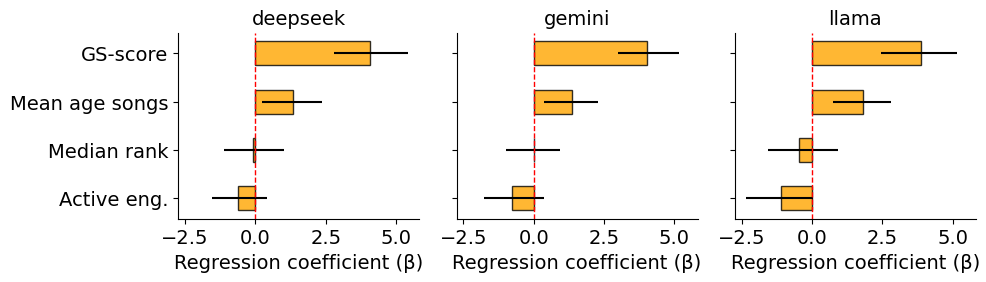

In [12]:
# Ensure all predictors appear in every plot_model
all_predictors = plot_df['predictor'].unique()
all_models = plot_df['plot_model'].unique()

# Pad missing predictors with NaNs
padded = []
for model in all_models:
    model_df = plot_df[plot_df['plot_model'] == model]
    missing_preds = set(all_predictors) - set(model_df['predictor'])

    # Add existing rows as dicts
    padded.extend(model_df.to_dict(orient='records'))

    # Add missing rows
    for pred in missing_preds:
        padded.append({
            'plot_model': model,
            'predictor': pred,
            'mean': np.nan,
            'ci_lower': np.nan,
            'ci_upper': np.nan
        })

plot_df = pd.DataFrame(padded)

predictor_means = (
    plot_df.groupby('predictor')['mean']
    .mean()
    .sort_values()
    .reset_index()
)

# Assign global order
predictor_order = {p: i for i, p in enumerate(predictor_means['predictor'])}
plot_df['predictor_ordered'] = plot_df['predictor'].map(predictor_order)

g = sns.FacetGrid(
    data=plot_df,
    col='plot_model',
    sharex=True,
    sharey=True,
    height=2.8,
    aspect=1.2
)

def plot_bars_with_ci(data, color, **kwargs):
    # Sort inside the plotting function to preserve order per facet
    data = data.sort_values('predictor_ordered')
    y_positions = range(len(data))
    plt.barh(
        y=y_positions,
        width=data['mean'],
        xerr=[data['mean'] - data['ci_lower'], data['ci_upper'] - data['mean']],
        color=color,
        edgecolor='black',
        height=0.5,
        alpha=0.8
    )
    plt.yticks(y_positions, data['predictor'])

g.map_dataframe(plot_bars_with_ci, color='orange')

# Add vertical line at zero
for ax in g.axes.flat:
    ax.axvline(0, color='red', linestyle='--', linewidth=1)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Regression coefficient (β)")

In [13]:
params = ['Blues', 'Classical', 'Comedy',
       'Country', 'Electronic', 'Folk', 'French chanson', 'Jazz', 'Metal',
       'Miscellaneous', 'Pop', 'Rap', 'Rock', 'Soul', 'Stage & Screen',
       'World', 'Afghanistan', 'Algeria','Argentina', 'Australia', 'Austria', 'Belgium', 'Benin', 'Brazil',
       'Canada', 'Cape Verde', 'Chile', 'China', 'Colombia', 'Cuba',
       'Democratic Republic of the Congo', 'Denmark', 'Egypt', 'England',
       'Finland', 'France', 'Germany', 'Iceland', 'India', 'Ireland',
       'Italy', 'Jamaica', 'Japan', 'Lebanon', 'Mexico', 'Morocco',
       'Netherlands', 'New Zealand', 'Niger', 'Nigeria', 'Norway',
       'Occupied Palestinian Territory', 'Panama', 'Poland',
       'Puerto Rico', 'Republic of Korea', 'Russian Federation',
       'Scotland', 'Senegal', 'Serbia', 'Slovenia', 'South Africa',
       'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Tunisia', 'Turkey',
       'Ukraine', 'UK', 'US','Cameroon', 'Croatia', 'Dominican Republic', 'Greece',
       'Islamic Republic Of Iran', 'Lithuania', 'Mali', 'Monaco',
       'Northern Ireland', 'Peru', 'Portugal', 'Venezuela', 'Wales',
       'Armenia', 'Ecuador', 'Hungary', 'Israel', 'Libya', 'Singapore',
       'Trinidad And Tobago', 'Hong Kong']

temp2 = df[df.model == 'deepseek-r1'].groupby('user_id')[params].median()

In [14]:
#we  consider only genres and countries that appear in the listening histories of at least 20% of the users 
feature_presence = (temp2 > 0).mean(axis=0)
mask = feature_presence > 0.2
predictors = temp2.loc[:, mask].columns.values

In [15]:
predictors =  np.append(predictors,np.array(['genre_entropy','genre_none','country_entropy','country_none']))
predictors

array(['Electronic', 'Folk', 'French chanson', 'Jazz', 'Metal', 'Pop',
       'Rap', 'Rock', 'Soul', 'World', 'Belgium', 'Brazil', 'Canada',
       'England', 'France', 'Germany', 'UK', 'US', 'genre_entropy',
       'genre_none', 'country_entropy', 'country_none'], dtype=object)

In [16]:
n_bootstrap = 500 #5000 in the paper
outcome = 'delta_rating' #can also be recall and ndcg 

In [17]:
results = []

for model in df.model.unique():
    temp = df[df.model == model].dropna().copy()
    temp[predictors] = scaler.fit_transform(temp[predictors])

    for predictor in tqdm(predictors):
        coefs = []

        for _ in range(n_bootstrap):
            sample = resample(temp)
            x_sample = sample[predictor].values.reshape(-1, 1)
            y_sample = sample[outcome].values
            reg = LinearRegression().fit(x_sample, y_sample)
            # Get index of current predictor
            coef = reg.coef_[0]
            coefs.append(coef)

        coefs = np.array(coefs)
        mean_coef = np.mean(coefs)
        ci_lower = np.percentile(coefs, 2.5)
        ci_upper = np.percentile(coefs, 97.5)

        p_value = np.mean(coefs * mean_coef < 0)

        results.append({
            'model': model,
            'predictor': predictor,
            'mean': mean_coef,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'p_value': p_value,
        })

# Convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:30<00:00,  1.40s/it]


In [18]:
results_df['plot_model'] = 'llama'
results_df.loc[results_df.model == 'deepseek-r1', 'plot_model'] = 'deepseek'
results_df.loc[results_df.model == 'gemini-2.0-flash', 'plot_model'] = 'gemini'

results_df.loc[results_df.predictor == 'genre_entropy', 'predictor'] = 'Genre entropy'
results_df.loc[results_df.predictor == 'country_entropy', 'predictor'] = 'Country entropy'
results_df.loc[results_df.predictor == 'World', 'predictor'] = 'World music'

results_df.loc[results_df.predictor == 'country_none', 'predictor'] = 'Country missing'
results_df.loc[results_df.predictor == 'genre_none', 'predictor'] = 'Genre missing'

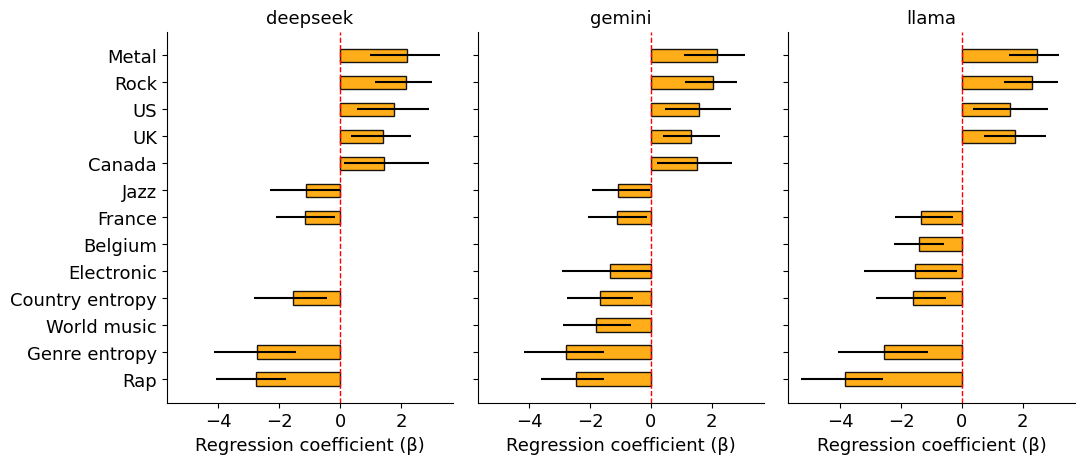

In [19]:
plt.rcParams.update({'font.size': 13})
results_df['to_plot'] = results_df['ci_lower'] * results_df['ci_upper']
results_df['ci_width'] = results_df['ci_upper'] - results_df['ci_lower']

plot_df = results_df[(results_df['p_value'] < 10)&(results_df['to_plot'] > 0)].copy()

# Ensure all predictors appear in every plot_model
all_predictors = plot_df['predictor'].unique()
all_models = plot_df['plot_model'].unique()

# Pad missing predictors with NaNs
padded = []
for model in all_models:
    model_df = plot_df[plot_df['plot_model'] == model]
    missing_preds = set(all_predictors) - set(model_df['predictor'])

    # Add existing rows as dicts
    padded.extend(model_df.to_dict(orient='records'))

    # Add missing rows
    for pred in missing_preds:
        padded.append({
            'plot_model': model,
            'predictor': pred,
            'mean': np.nan,
            'ci_lower': np.nan,
            'ci_upper': np.nan
        })

plot_df = pd.DataFrame(padded)

predictor_means = (
    plot_df.groupby('predictor')['mean']
    .mean()
    .sort_values()
    .reset_index()
)

# Assign global order
predictor_order = {p: i for i, p in enumerate(predictor_means['predictor'])}
plot_df['predictor_ordered'] = plot_df['predictor'].map(predictor_order)

g = sns.FacetGrid(
    data=plot_df,
    col='plot_model',
    sharex=True,
    sharey=True,
    height=4.6,
    aspect=0.8
)

def plot_bars_with_ci(data, color, **kwargs):
    # Sort inside the plotting function to preserve order per facet
    data = data.sort_values('predictor_ordered')
    y_positions = range(len(data))
    plt.barh(
        y=y_positions,
        width=data['mean'],
        xerr=[data['mean'] - data['ci_lower'], data['ci_upper'] - data['mean']],
        color=color,
        edgecolor='black',
        height=0.5,
        alpha=0.9
    )
    plt.yticks(y_positions, data['predictor'])

g.map_dataframe(plot_bars_with_ci, color='orange')

# Add vertical line at zero
for ax in g.axes.flat:
    ax.axvline(0, color='red', linestyle='--', linewidth=1)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Regression coefficient (β)")